In [1]:
import json

import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches
import numpy as np

In [2]:
path_raw_results: str = '../../benchmark_results/raw.csv'
df: pd.DataFrame = pd.read_csv(path_raw_results)

base_model_name: str = 'Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth-meta-llama-3.1-4bit-plain-t0.0'

## Group Data

In [3]:
columns_to_keep_raw_csv: list = ['game', 'model', 'experiment', 'episode', 'Aborted', 'Lose', 'Success']

def group_raw_csv(data: pd.DataFrame, columns_to_keep: list[str]) -> pd.DataFrame:
    df: pd.DataFrame = data.pivot_table(
        index=['game', 'model', 'experiment', 'episode'],
        columns=['metric'],
        values='value'
    ).reset_index()

    columns_to_drop: list = [column for column in list(df.keys()) if column not in columns_to_keep]
    return df.drop(columns=columns_to_drop, axis=0)

clean_csv_data: pd.DataFrame = group_raw_csv(data=df, columns_to_keep=columns_to_keep_raw_csv)

# utils

In [4]:
# this works for taboo, and all wordle games
def get_term_from_episode(row):
    model_name = row['model']
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']
    
    path: str = f'../../benchmark_results/{model_name}/{game}/{experiment}/{episode}/instance.json'
    instance: dict = json.load(open(path))
    return instance['target_word']

# this works for image game and referencegame and private shared
def get_generic_turn_name(row):
    experiment_name = row['experiment']
    episode = row['episode']
    return f'{experiment_name[2:]}-{episode.split("_")[1]}'

def prepare_model_names(raw_names: list) -> list:
    return [m.split("--")[0].split("-t0")[0] for m in raw_names]

def prepare_value(row):
    if row['Success'] == 1.0: return 'Success'
    if row['Lose'] == 1.0: return 'Loss'
    if row['Aborted'] == 1.0: return 'Aborted'
    return 'Undefined'

def prepare_model_data(model_name, data_frame: pd.DataFrame, get_turn_name) -> pd.DataFrame:
    df: pd.DataFrame = data_frame[data_frame.model == model_name]
    data_base_model: dict = {}
    
    for index, row in df.iterrows():
        data_base_model.update({get_turn_name(row): prepare_value(row)})
        
    return data_base_model


def reorder_columns(df: pd.DataFrame) -> pd.DataFrame:
    original_columns = df.columns.tolist()
    running_columns = df.columns.tolist()
    rearranged_columns = []

    ## collect all values that are aborted
    for column in running_columns:
        if len(df[column].unique()) == 1 and df[column].iloc[0] == 'Aborted':
            rearranged_columns.append(column)

    running_columns = [r for r in running_columns if r not in rearranged_columns]

    ## collect all values that are aborted
    for column in running_columns:
        if df[column].iloc[0] == 'Aborted':
            rearranged_columns.append(column)

    running_columns = [r for r in running_columns if r not in rearranged_columns]

    for column in running_columns:
        if len(df[column].unique()) == 1 and df[column].iloc[0] == 'Loss':
            rearranged_columns.append(column)

    running_columns = [r for r in running_columns if r not in rearranged_columns]

    for column in running_columns:
        if df[column].iloc[0] == 'Loss':
            rearranged_columns.append(column)

    running_columns = [r for r in running_columns if r not in rearranged_columns]

    for column in running_columns:
        if len(df[column].unique()) == 1 and df[column].iloc[0] == 'Success':
            rearranged_columns.append(column)

    running_columns = [r for r in running_columns if r not in rearranged_columns]

    for column in running_columns:
        if df[column].iloc[0] == 'Success':
            rearranged_columns.append(column)

    assert len(rearranged_columns) == len(original_columns)

    return rearranged_columns, original_columns

In [5]:
# list of all games
games = list(set(list(clean_csv_data.game)))

# only consider these models for eval
models_to_consider: list = ['Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth-meta-llama-3.1-4bit-plain-t0.0',
                            'llama3.1-sft-e1-_E1_D10001-t0.0--llama3.1-sft-e1-_E1_D10001-t0.0',
                            'llama3.1-sft-e1-_E1_D20001-t0.0--llama3.1-sft-e1-_E1_D20001-t0.0',
                            'llama3.1-sft-e1-_E1_D20002-t0.0--llama3.1-sft-e1-_E1_D20002-t0.0',
                            'llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e1-_E1_D20003-t0.0',
                            'llama3.1-sft-e1-_E1_D30001-t0.0--llama3.1-sft-e1-_E1_D30001-t0.0',
                            'llama3.1-sft-e1-_E1_D30002-t0.0--llama3.1-sft-e1-_E1_D30002-t0.0',
                            'llama3.1-sft-e1-_E1_D30003-t0.0--llama3.1-sft-e1-_E1_D30003-t0.0',
                            'llama3.1-sft-e1-_E1_D30004-t0.0--llama3.1-sft-e1-_E1_D30004-t0.0']

turn_extraction_lookup = {
    'wordle': get_term_from_episode,
    'wordle_withclue': get_term_from_episode,
    'wordle_withcritic': get_term_from_episode,
    'taboo': get_term_from_episode,
    'imagegame': get_generic_turn_name,
    'referencegame': get_generic_turn_name,
    'privateshared': get_generic_turn_name,
}

custom_height_lookup = {
    'wordle': 3,
    'wordle_withclue': 3,
    'wordle_withcritic': 3,
    'taboo': 3.7,
    'imagegame': 3.8,
    'referencegame': 5,
    'privateshared': 3.7,
}

custom_width_lookup = {
    'wordle': 11,
    'wordle_withclue': 11,
    'wordle_withcritic': 11,
    'taboo': 15,
    'imagegame': 11,
    'referencegame': 30,
    'privateshared': 15,
}

## Set up the plotting

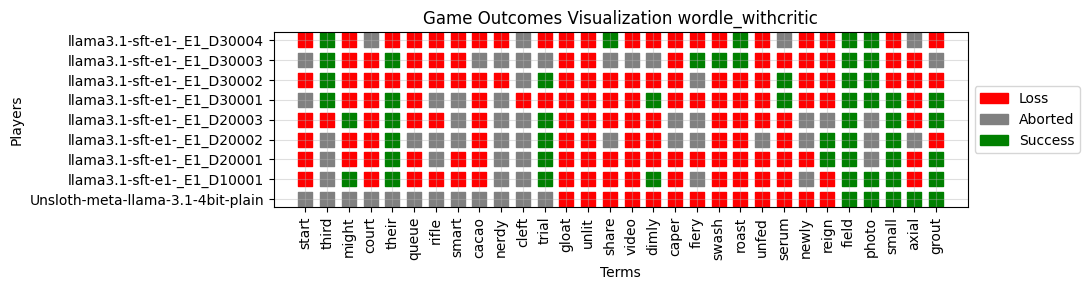

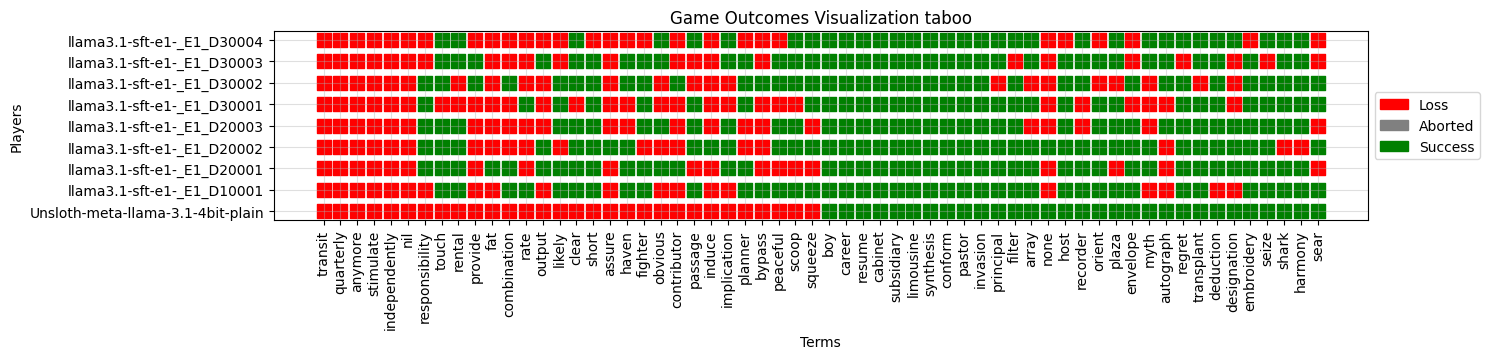

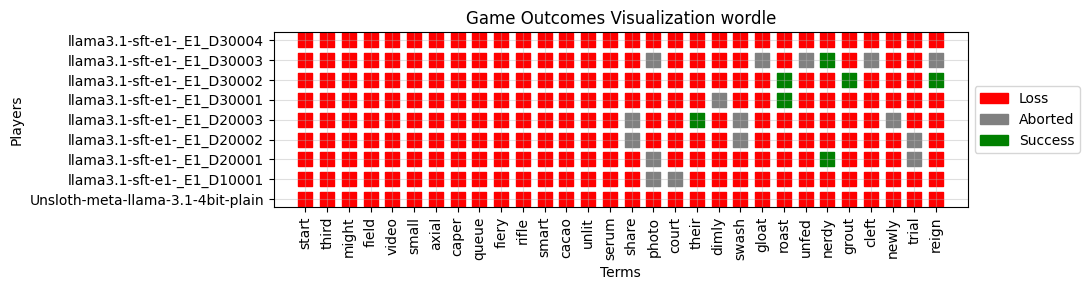

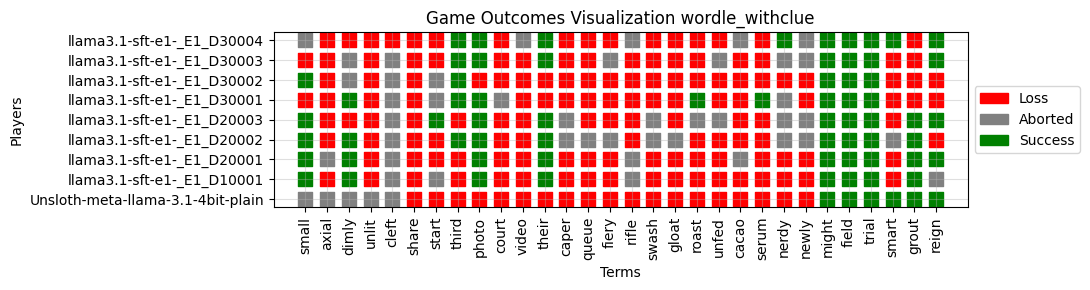

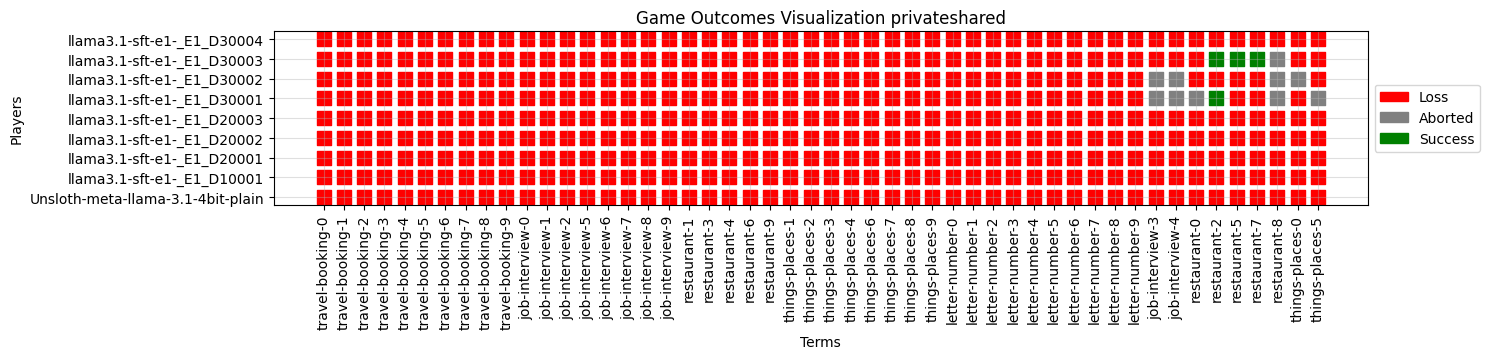

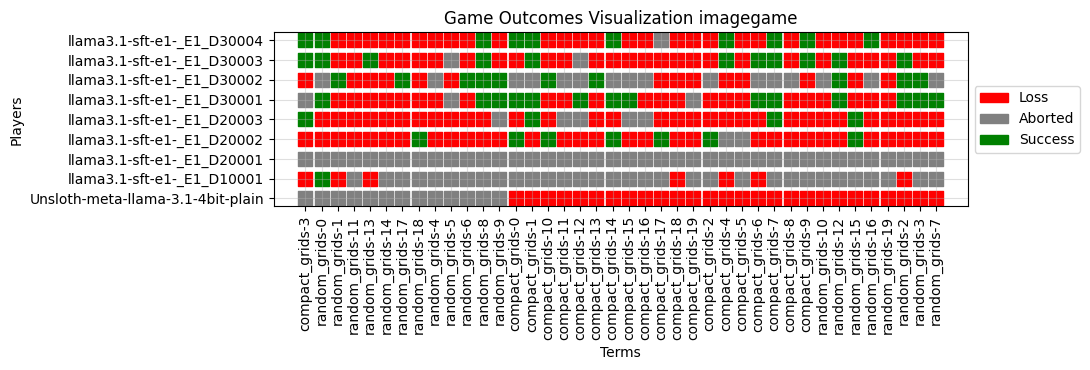

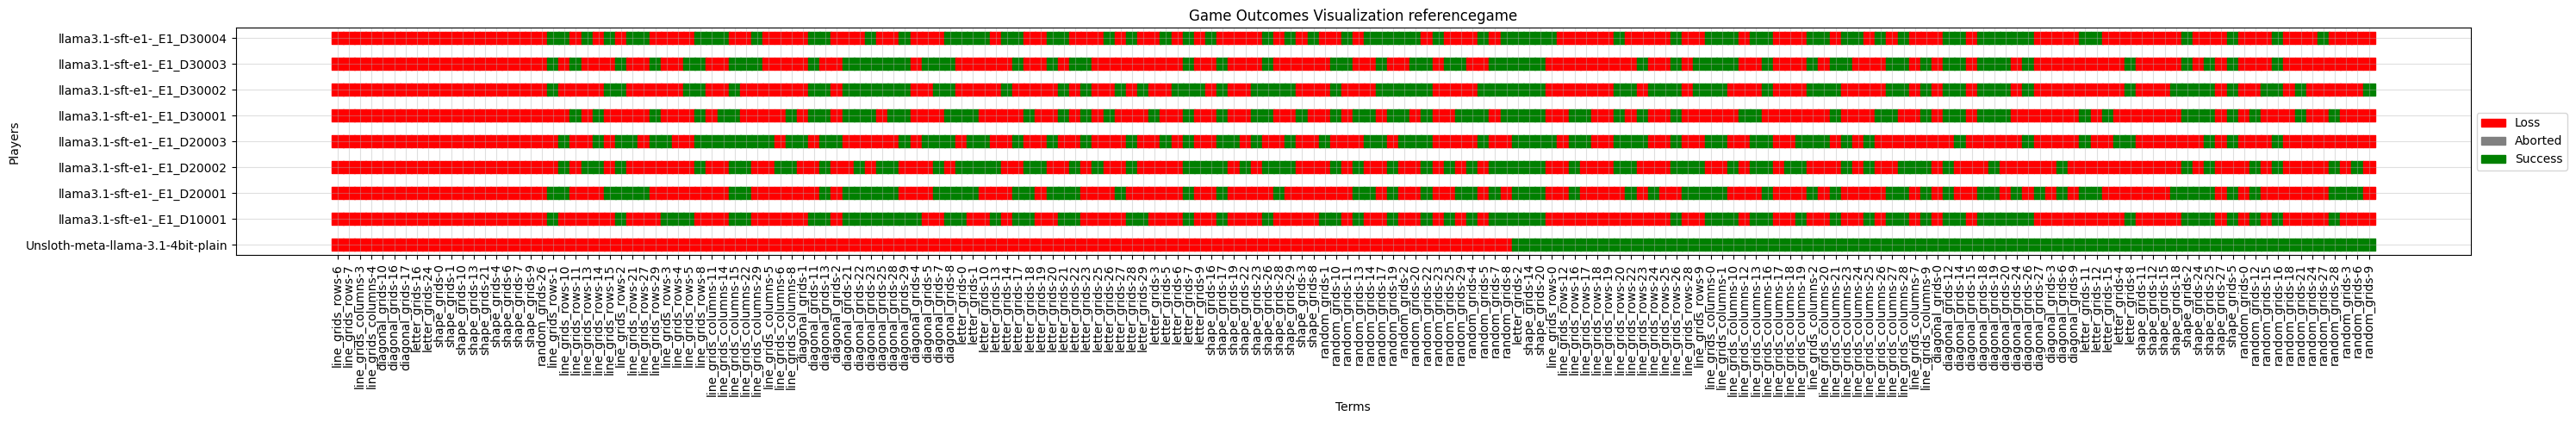

In [6]:
for game in games:
    game_data = clean_csv_data[clean_csv_data.game == game]

    plot_data: dict = {}
    for model_name, short_name in zip(models_to_consider, prepare_model_names(models_to_consider)):
        prep_data = prepare_model_data(model_name, game_data, turn_extraction_lookup[game])
        plot_data.update({short_name: prep_data})
    
    
    df = pd.DataFrame(plot_data)
    df_transposed = df.T
    
    reordered_columns, original_columns = reorder_columns(df_transposed)
    df_reordered = df_transposed[reordered_columns].T

    # Sample data
    players = prepare_model_names(models_to_consider)
    terms = list(df_reordered.index)
    
    # Create a dictionary to map outcomes to colors
    color_map = {'Success': 'green', 'Loss': 'red', 'Aborted': 'gray', 'Undefined': 'lightblue'}
    
    # Sample data structure (replace with your actual data)
    data = df_reordered
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(custom_width_lookup[game], custom_height_lookup[game]))
    
    # Plot data points
    for i, player in enumerate(players):
        for j, term in enumerate(terms):
            outcome = data[player][term]
            ax.scatter(j, i, color=color_map[outcome], s=100, marker='s')
    
    # Customize axes
    ax.set_xticks(range(len(terms)))
    ax.set_xticklabels(terms)
    plt.xticks(rotation=90)
    
    ax.set_yticks(range(len(players)))
    ax.set_yticklabels(players)
    
    # Add labels and title
    ax.set_xlabel('Terms')
    ax.set_ylabel('Players')
    ax.set_title(f'Game Outcomes Visualization {game}')
    
    # Add a grid for better readability
    ax.grid(True, linestyle='-', alpha=0.4)
    
    
    # Creating legend with color box
    color_box_loss = mpatches.Patch(color='red', label='Loss')
    color_box_aborted = mpatches.Patch(color='gray', label='Aborted')
    color_box_success = mpatches.Patch(color='green', label='Success')
    
    plt.legend(handles=[color_box_loss, color_box_aborted, color_box_success],loc='center left', bbox_to_anchor=(1, 0.5))
    
    
    plt.tight_layout()
    plt.savefig(f'../../plots/success_abort_rate_{game}.png')
    plt.show()

In [7]:
clean_csv_data.head()

metric,game,model,experiment,episode,Aborted,Lose,Success
0,imagegame,ClemBench-SFT-Nicola-Test-t0.0--ClemBench-SFT-...,0_compact_grids,episode_0,1.0,0.0,0.0
1,imagegame,ClemBench-SFT-Nicola-Test-t0.0--ClemBench-SFT-...,0_compact_grids,episode_1,1.0,0.0,0.0
2,imagegame,ClemBench-SFT-Nicola-Test-t0.0--ClemBench-SFT-...,0_compact_grids,episode_10,1.0,0.0,0.0
3,imagegame,ClemBench-SFT-Nicola-Test-t0.0--ClemBench-SFT-...,0_compact_grids,episode_11,1.0,0.0,0.0
4,imagegame,ClemBench-SFT-Nicola-Test-t0.0--ClemBench-SFT-...,0_compact_grids,episode_12,1.0,0.0,0.0


In [8]:
all_games = list(clean_csv_data.game.unique())
columns_to_keep = ['game', 'model', 'Aborted', 'Lose', 'Success']
cleaned_data = clean_csv_data[columns_to_keep]
cleaned_data = cleaned_data[cleaned_data.model.isin(models_to_consider)]

In [9]:
cleaned_data.groupby(['game', 'model']).agg({'Aborted': 'sum', 'Lose': 'sum', 'Success': 'sum'})

metric                                                                Aborted  \
game              model                                                         
imagegame         Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth...     13.0   
                  llama3.1-sft-e1-_E1_D10001-t0.0--llama3.1-sft-e...     32.0   
                  llama3.1-sft-e1-_E1_D20001-t0.0--llama3.1-sft-e...     40.0   
                  llama3.1-sft-e1-_E1_D20002-t0.0--llama3.1-sft-e...      2.0   
                  llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e...      5.0   
...                                                                       ...   
wordle_withcritic llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e...      8.0   
                  llama3.1-sft-e1-_E1_D30001-t0.0--llama3.1-sft-e...      4.0   
                  llama3.1-sft-e1-_E1_D30002-t0.0--llama3.1-sft-e...      2.0   
                  llama3.1-sft-e1-_E1_D30003-t0.0--llama3.1-sft-e...      9.0   
                  llama3.1-sft-e1-_E1_D30004-t0.0--llama3.1-sft-e...      4.0   

metric                                                                Lose  \
game              model                                                      
imagegame         Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth...  27.0   
                  llama3.1-sft-e1-_E1_D10001-t0.0--llama3.1-sft-e...   7.0   
                  llama3.1-sft-e1-_E1_D20001-t0.0--llama3.1-sft-e...   0.0   
                  llama3.1-sft-e1-_E1_D20002-t0.0--llama3.1-sft-e...  31.0   
                  llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e...  31.0   
...                                                                    ...   
wordle_withcritic llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e...  16.0   
                  llama3.1-sft-e1-_E1_D30001-t0.0--llama3.1-sft-e...  18.0   
                  llama3.1-sft-e1-_E1_D30002-t0.0--llama3.1-sft-e...  23.0   
                  llama3.1-sft-e1-_E1_D30003-t0.0--llama3.1-sft-e...  14.0   
                  llama3.1-sft-e1-_E1_D30004-t0.0--llama3.1-sft-e...  21.0   

metric                                                                Success  
game              model                                                        
imagegame         Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth...      0.0  
                  llama3.1-sft-e1-_E1_D10001-t0.0--llama3.1-sft-e...      1.0  
                  llama3.1-sft-e1-_E1_D20001-t0.0--llama3.1-sft-e...      0.0  
                  llama3.1-sft-e1-_E1_D20002-t0.0--llama3.1-sft-e...      7.0  
                  llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e...      4.0  
...                                                                       ...  
wordle_withcritic llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e...      6.0  
                  llama3.1-sft-e1-_E1_D30001-t0.0--llama3.1-sft-e...      8.0  
                  llama3.1-sft-e1-_E1_D30002-t0.0--llama3.1-sft-e...      5.0  
                  llama3.1-sft-e1-_E1_D30003-t0.0--llama3.1-sft-e...      7.0  
                  llama3.1-sft-e1-_E1_D30004-t0.0--llama3.1-sft-e...      5.0  

[63 rows x 3 columns]

In [10]:
# Assuming you've already performed the groupby and aggregation
aggregated_data = cleaned_data.groupby(['game', 'model']).agg({'Aborted': 'sum', 'Lose': 'sum', 'Success': 'sum'})

# Calculate the total attempts for each group
aggregated_data['Total'] = aggregated_data['Aborted'] + aggregated_data['Lose'] + aggregated_data['Success']

# Calculate the ratios
aggregated_data['Success_ratio'] = (aggregated_data['Success'] / aggregated_data['Total'])*100
aggregated_data['Lose_ratio'] = (aggregated_data['Lose'] / aggregated_data['Total'])*100
aggregated_data['Aborted_ratio'] = (aggregated_data['Aborted'] / aggregated_data['Total'])*100

# Reset the index if you want 'game' and 'model' as columns
aggregated_data = aggregated_data.reset_index()

In [11]:
aggregated_data.head()

metric,game,model,Aborted,Lose,Success,Total,Success_ratio,Lose_ratio,Aborted_ratio
0,imagegame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,13.0,27.0,0.0,40.0,0.0,67.5,32.5
1,imagegame,llama3.1-sft-e1-_E1_D10001-t0.0--llama3.1-sft-...,32.0,7.0,1.0,40.0,2.5,17.5,80.0
2,imagegame,llama3.1-sft-e1-_E1_D20001-t0.0--llama3.1-sft-...,40.0,0.0,0.0,40.0,0.0,0.0,100.0
3,imagegame,llama3.1-sft-e1-_E1_D20002-t0.0--llama3.1-sft-...,2.0,31.0,7.0,40.0,17.5,77.5,5.0
4,imagegame,llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-...,5.0,31.0,4.0,40.0,10.0,77.5,12.5


In [21]:
def create_sectioned_markdown_table(df):
    # Define the model that should always be first
    first_model = 'Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth-meta-llama-3.1-4bit-plain-t0.0'

    # Create a custom sort order
    df['sort_order'] = df['model'].apply(lambda x: 0 if x == first_model else 1)

    # Get a consistent order for all other models
    other_models = sorted(df[df['model'] != first_model]['model'].unique())
    model_order = {model: idx + 1 for idx, model in enumerate(other_models)}

    # Apply the secondary sort order for non-first models
    df['secondary_order'] = df['model'].apply(lambda x: model_order.get(x, 0))

    # Sort the entire dataframe
    df = df.sort_values(['game', 'sort_order', 'secondary_order'])

    # Create the base header template
    header = '| Model | Success Ratio | Lose Ratio | Abort Ratio |\n|-------|---------------|------------|-------------|\n'

    # Initialize the result string
    result = []

    # Process each game separately
    for game_name, game_df in df.groupby('game'):
        result.append(f"\n## Game: {game_name}")
        result.append(header)
        rows = game_df.apply(lambda row: f'| {row.model} | {row.Success_ratio:.2f} | {row.Lose_ratio:.2f} | {row.Aborted_ratio:.2f} |',
                             axis=1).to_list()
        result.append('\n'.join(rows))

    return '\n'.join(result)
    
print(create_sectioned_markdown_table(aggregated_data))


## Game: imagegame
| Model | Success Ratio | Lose Ratio | Abort Ratio |
|-------|---------------|------------|-------------|

| Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth-meta-llama-3.1-4bit-plain-t0.0 | 0.00 | 67.50 | 32.50 |
| llama3.1-sft-e1-_E1_D10001-t0.0--llama3.1-sft-e1-_E1_D10001-t0.0 | 2.50 | 17.50 | 80.00 |
| llama3.1-sft-e1-_E1_D20001-t0.0--llama3.1-sft-e1-_E1_D20001-t0.0 | 0.00 | 0.00 | 100.00 |
| llama3.1-sft-e1-_E1_D20002-t0.0--llama3.1-sft-e1-_E1_D20002-t0.0 | 17.50 | 77.50 | 5.00 |
| llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e1-_E1_D20003-t0.0 | 10.00 | 77.50 | 12.50 |
| llama3.1-sft-e1-_E1_D30001-t0.0--llama3.1-sft-e1-_E1_D30001-t0.0 | 35.00 | 57.50 | 7.50 |
| llama3.1-sft-e1-_E1_D30002-t0.0--llama3.1-sft-e1-_E1_D30002-t0.0 | 25.00 | 35.00 | 40.00 |
| llama3.1-sft-e1-_E1_D30003-t0.0--llama3.1-sft-e1-_E1_D30003-t0.0 | 27.50 | 67.50 | 5.00 |
| llama3.1-sft-e1-_E1_D30004-t0.0--llama3.1-sft-e1-_E1_D30004-t0.0 | 25.00 | 72.50 | 2.50 |

## Game: privateshared
| Mod